### SO here is the situation -- the required weather data is very hard to find for many locations for various metrics. For example, I haven't been able to find 24 precipitation for large portions of Canada. This emphasizes the need for alternative "reduced data" methods to determine the FWI. I'd like to try to build a machine learning model that can predict FWI based on temperature and wind speed alone (or some other combination).

In [1]:
import keras
import pandas as pd

In [2]:
singleDay = pd.read_csv(os.path.dirname(os.getcwd()) + os.sep + 'data' + os.sep + "single_day_climate_data.csv")

# THese missing flags are actually mostly incorrect
#simpleDF=singleDay.query("TOTAL_PRECIPITATION_FLAG != 'M' and MEAN_TEMPERATURE_FLAG !='M' and SPEED_MAX_GUST_FLAG !='M' and MAX_REL_HUMIDITY_FLAG !='M'")

# Let's get the data for the stations that aren't missing any of the data (at least for this day)
simpleDF = singleDay.query("TOTAL_PRECIPITATION > -1000 and MEAN_TEMPERATURE > -1000 and SPEED_MAX_GUST > -1000 and MAX_REL_HUMIDITY > -1000")[['x','y','STATION_NAME','MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST','TOTAL_PRECIPITATION']]


In [3]:
import math
# “”” Define Class FWI Class first”””
class FWICLASS:
    def __init__(self,temp,rhum,wind,prcp):
        self.h = rhum
        self.t = temp
        self.w = wind
        self.p = prcp
    def FFMCcalc(self,ffmc0):
        mo = (147.2*(101.0 - ffmc0))/(59.5 + ffmc0) #*Eq. 1*#
        if (self.p > 0.5):
            rf = self.p - 0.5 #*Eq. 2*#%%!
            if(mo > 150.0):
                mo = (mo+42.5*rf*math.exp(-100.0/(251.0-mo))*(1.0 - math.exp(-6.93/rf))) + (.0015*(mo - 150.0)**2)*math.sqrt(rf) #*Eq. 3b*#
            elif mo <= 150.0:
                mo = mo+42.5*rf*math.exp(-100.0/(251.0-mo))*(1.0 - math.exp(-6.93/rf)) #*Eq. 3a*#
        if(mo > 250.0):
            mo = 250.0
        ed = .942*(self.h**.679) + (11.0*math.exp((self.h-100.0)/10.0))+0.18*(21.1-self.t)*(1.0 - 1.0/math.exp(.1150 * self.h)) #*Eq. 4*#
        if(mo < ed):
            ew = .618*(self.h**.753) + (10.0*math.exp((self.h-100.0)/10.0))+ .18*(21.1-self.t)*(1.0 - 1.0/math.exp(.115 * self.h)) #*Eq. 5*#
            if(mo <= ew):
                kl = .424*(1.0-((100.0-self.h)/100.0)**1.7)+(.0694*math.sqrt(self.w))*(1.0 - ((100.0 - self.h)/100.0)**8) #*Eq. 7a*#
                kw = kl * (.581 * math.exp(.0365 * self.t)) #*Eq. 7b*#
                m = ew - (ew - mo)/10.0**kw #*Eq. 9*#
            elif mo > ew:
                m = mo
        elif(mo == ed):
            m = mo
        elif mo > ed:
            kl =.424*(1.0-(self.h/100.0)**1.7)+(.0694*math.sqrt(self.w))* (1.0-(self.h/100.0)**8) #*Eq. 6a*#
            kw = kl * (.581*math.exp(.0365*self.t)) #*Eq. 6b*#
            m = ed + (mo-ed)/10.0 ** kw #*Eq. 8*#
        ffmc = (59.5 * (250.0 -m)) / (147.2 + m)
        if (ffmc > 101.0):
            ffmc = 101.0
        if (ffmc <= 0.0):
            ffmc = 0.0
        return ffmc
#*Eq. 10*#
    def DMCcalc(self,dmc0,mth):
        el = [6.5,7.5,9.0,12.8,13.9,13.9,12.4,10.9,9.4,8.0,7.0,6.0]
        t = self.t
        if (t < -1.1):
            t = -1.1
        rk = 1.894*(t+1.1) * (100.0-self.h) * (el[mth-1]*0.0001) #*Eqs. 16 and 17*#

        if self.p > 1.5:
            ra= self.p
            rw = 0.92*ra - 1.27
            wmi = 20.0 + 280.0/math.exp(0.023*dmc0)
            if dmc0 <= 33.0:
                b = 100.0 /(0.5 + 0.3*dmc0)
            elif dmc0 > 33.0:
                if dmc0 <= 65.0:
                    b = 14.0 - 1.3*math.log(dmc0)
            elif dmc0 > 65.0:
                b = 6.2 * math.log(dmc0) - 17.2
            wmr = wmi + (1000*rw) / (48.77+b*rw)
            pr = 43.43 * (5.6348 - math.log(wmr-20.0))
        elif self.p <= 1.5:
            pr = dmc0
        if (pr<0.0):
            pr = 0.0
        dmc = pr + rk
        if(dmc<= 1.0):
            dmc = 1.0
        return dmc


    def DCcalc(self,dc0,mth):
        fl = [-1.6, -1.6, -1.6, 0.9, 3.8, 5.8, 6.4, 5.0, 2.4, 0.4, -1.6, -1.6]
        t = self.t
        if(t < -2.8):
            t = -2.8
        pe = (0.36*(t+2.8) + fl[mth-1] )/2
        if pe <=0.0:
            pe = 0.0
        #*Eq. 22*#
        if (self.p > 2.8):
            ra = self.p
            rw = 0.83*ra - 1.27 #*Eq. 18*#
            smi = 800.0 * math.exp(-dc0/400.0) #*Eq. 19*#
            dr = dc0 - 400.0*math.log( 1.0+((3.937*rw)/smi) ) #*Eqs. 20 and 21*#
            if (dr > 0.0):
                dc = dr + pe
            else: dc = dc0
        #elif self.p <= 2.8:
        else:
            dc = dc0 + pe
        return dc


    def ISIcalc(self,ffmc):
        mo = 147.2*(101.0-ffmc) / (59.5+ffmc)
        ff = 19.115*math.exp(mo*-0.1386) * (1.0+(mo**5.31)/49300000.0)
        isi = ff * math.exp(0.05039*self.w)
        return isi


    def BUIcalc(self,dmc,dc):
        if dmc <= 0.4*dc:
            bui = (0.8*dc*dmc) / (dmc+0.4*dc)
        else:
            bui = dmc-(1.0-0.8*dc/(dmc+0.4*dc))*(0.92+(0.0114*dmc)**1.7)
        if bui <0.0:
            bui = 0.0
        return bui


    def FWIcalc(self,isi,bui):
        if bui <= 80.0:
            bb = 0.1 * isi * (0.626*bui**0.809 + 2.0)
        else:
            bb = 0.1*isi*(1000.0/(25. + 108.64/math.exp(0.023*bui)))
        if(bb <= 1.0):
            fwi = bb
        else:
            fwi = math.exp(2.72 * (0.434*math.log(bb))**0.647)

        return fwi


def main():
    ffmc0 = 85.0
    dmc0 = 6.0
    dc0 = 15.0
    infile = open('test_in_fwi.txt','r')
    outfile = open('fwioutput.txt','w')
    try:
        for line in infile:
            mth,day,temp,rhum,wind,prcp=[float(field) for field in line.strip().lstrip('[').rstrip(']').split()]
            if rhum>100.0:
                rhum = 100.0
            mth = int(mth)
            fwisystem = FWICLASS(temp,rhum,wind,prcp)
            ffmc = fwisystem.FFMCcalc(ffmc0)
            dmc = fwisystem.DMCcalc(dmc0,mth)
            dc = fwisystem.DCcalc(dc0,mth)
            isi = fwisystem.ISIcalc(ffmc)
            bui = fwisystem.BUIcalc(dmc,dc)
            fwi = fwisystem.FWIcalc(isi,bui)
            ffmc0 = ffmc
            dmc0 = dmc
            dc0 = dc
            print(str(ffmc),str(dmc),str(dc),str(isi),str(bui),str(fwi))
    finally:
        infile.close()
        outfile.close()
main()

def computeFWI(temp,rhum,prcp,wind,mth):
    ffmc0 = 85.0
    dmc0 = 6.0
    dc0 = 15.0

    if rhum>100.0:
        rhum = 100.0
    mth = int(mth)
    fwisystem = FWICLASS(temp,rhum,wind,prcp)
    ffmc = fwisystem.FFMCcalc(ffmc0)
    dmc = fwisystem.DMCcalc(dmc0,mth)
    dc = fwisystem.DCcalc(dc0,mth)
    isi = fwisystem.ISIcalc(ffmc)
    bui = fwisystem.BUIcalc(dmc,dc)
    fwi = fwisystem.FWIcalc(isi,bui)
    ffmc0 = ffmc
    dmc0 = dmc
    dc0 = dc
    return fwi

# FROM https://publications.gc.ca/collections/collection_2016/rncan-nrcan/Fo133-1-424-eng.pdf

87.12550153156418 7.811796612 19.204 9.516918108321766 7.8039278404027135 8.705700639590445
90.8244737324999 11.674698630000002 25.028 10.802241217606626 11.60163827115898 11.549865177133597
77.63471875369589 11.112184754829832 27.49489140897453 1.5914554957643685 11.107277643541376 1.1193002660344609
90.21988710465098 16.188479766829833 35.29889140897453 13.40597459113381 16.121817741412364 15.890875255293292
65.31710438957165 9.79111185128955 23.010025331964645 1.3910938250537408 9.761933065289 0.8283486511031101
55.41626480735404 6.059921033103912 10.184518341592803 1.1877201080809798 5.87752455287238 0.549121999201251
80.84398999216936 9.667191765103912 16.368518341592804 1.8641589805082597 9.485649709445626 1.3929517266332863
61.741292230592016 7.150708726042811 17.26749308437178 1.2412291865095855 7.1345147457447196 0.6291345862151786
64.4820361685994 7.735685778042811 21.29149308437178 1.7303567635065653 8.107380366269709 0.9349073503101377
77.63396316147791 9.201024334042812 25

In [4]:
#OK let's output the state as a .csv just so we have SOMETHING)


#First, we need to compute the fwi
#Lets turn the data into a numpy array and then loop over it
numpysimpleDF = simpleDF[['MEAN_TEMPERATURE','MAX_REL_HUMIDITY','TOTAL_PRECIPITATION','SPEED_MAX_GUST']].to_numpy()

fwis = []
for i in range(len(numpysimpleDF)):
    fwis.append(computeFWI(numpysimpleDF[i][0],numpysimpleDF[i][1],numpysimpleDF[i][2],numpysimpleDF[i][3],11))

simpleDF["fwi"] = fwis
    
simpleDF.set_index("STATION_NAME")[['x','y','MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST','TOTAL_PRECIPITATION','fwi']].to_csv(os.path.dirname(os.getcwd()) + os.sep + 'data' + os.sep + "Initial_State.csv")

In [5]:
print(f"These are all the {len(simpleDF)} stations that have all 4 types of data (at least on november 2 2023)")

# There are 351 stations that have this data -- it actually feels like too  many for me to go through manually and select them.
# What if I just take ALL station data from the last like 10 years or something and just filter out all the ones that are missing data?

for i in range(len(simpleDF.STATION_NAME)):
    print(simpleDF.STATION_NAME.sort_values().values[i])

These are all the 351 stations that have all 4 types of data (at least on november 2 2023)
ABBOTSFORD A
AGASSIZ RCS
ARGENTIA (AUT)
ARMSTRONG A
ARVIAT A
ARVIAT CLIMATE
ATTAWAPISKAT A
BACCARO PT
BADGER (AUT)
BAGOTVILLE A
BAIE-COMEAU
BAIE-COMEAU A
BAKER LAKE A
BAKER LAKE CLIMATE
BALLENAS ISLAND
BARRIE-ORO
BAS CARAQUET
BATHURST A
BATHURST INLET
BEATRICE CLIMATE
BEAUPORT
BEAVER MINES
BELLA BELLA
BELLA COOLA AIRPORT
BIG TROUT LAKE
BIG TROUT LAKE A
BONAVISTA
BONILLA ISLAND (AUT)
BOW VALLEY
BRANDON A
BRANTFORD AIRPORT
BRIER ISLAND
BROCKVILLE CLIMATE
BUFFALO NARROWS (AUT)
BUFFALO NARROWS A
BURGEO NL
CALGARY INT'L CS
CALGARY INTL A
CALGARY SPRINGBANK A
CAMBRIDGE BAY GSN
CAP-CHAT
CAP-MADELEINE
CAP-TOURMENTE
CAPE LIVERPOOL
CAPE ST JAMES
CARBERRY CS
CARIBOU ISLAND (AUT)
CARIBOU POINT (AUT)
CARTWRIGHT A
CATHEDRAL POINT (AUT)
CHARLEVOIX (MRC)
CHARLO AUTO
CHARLOTTETOWN A
CHATHAM KENT
CHETICAMP HIGHLANDS NATIONAL PARK
CHEVERY
CHIBOUGAMAU CHAPAIS A
CHIBOUGAMAU-CHAPAIS
CHURCHILL A
CHURCHILL CLIMATE
CLARE

In [6]:
simpleDF_on = singleDay.query("TOTAL_PRECIPITATION > -1000 and MEAN_TEMPERATURE > -1000 and SPEED_MAX_GUST > -1000 and MAX_REL_HUMIDITY > -1000 and PROVINCE_CODE=='ON'")[['x','y','STATION_NAME','MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST','TOTAL_PRECIPITATION']]
for i in range(len(simpleDF_on.STATION_NAME)):
    print(simpleDF_on.STATION_NAME.sort_values().values[i])

ARMSTRONG A
ATTAWAPISKAT A
BARRIE-ORO
BEATRICE CLIMATE
BIG TROUT LAKE
BIG TROUT LAKE A
BRANTFORD AIRPORT
BROCKVILLE CLIMATE
CARIBOU ISLAND (AUT)
CHATHAM KENT
COBOURG (AUT)
DELHI CS
DRYDEN REGIONAL
EARLTON A
EARLTON CLIMATE
EGBERT CS
ELORA RCS
FORT SEVERN A
GODERICH
GORE BAY CLIMATE
GORE BAY-MANITOULIN
HAMILTON A
HARROW CDA AUTO
KAPUSKASING A
KAPUSKASING CDA ON
KEMPTVILLE CS
KENORA A
KENORA RCS
KINGSTON CLIMATE
KITCHENER/WATERLOO
LANSDOWNE HOUSE (AUT)
LANSDOWNE HOUSE A
MONO CENTRE
MOOSE CREEK WELLS
MOOSONEE
MOUNT FOREST (AUT)
NORTH BAY A
NORTH BAY AIRPORT
OGOKI POST A
OSHAWA
OTTAWA CDA RCS
OTTAWA INTL A
PEAWANUCK (AUT)
PEAWANUCK A
PETERBOROUGH A
PICKLE LAKE (AUT)
PICKLE LAKE A
POINT PETRE (AUT)
PORT WELLER (AUT)
PUKASKWA (AUT)
RIDGETOWN RCS
SARNIA
SARNIA CLIMATE
SAULT STE MARIE A
SAULT STE. MARIE AIRPORT
SIOUX LOOKOUT A
SIOUX LOOKOUT AIRPORT
SUDBURY A
SUDBURY CLIMATE
TERRACE BAY AIRPORT
TIMMINS A
TIMMINS CLIMATE
TOBERMORY RCS
TORONTO CITY CENTRE
TORONTO INTL A
TRENTON A
UXBRIDGE WEST
VI

### A small subset of the data is included on the github, but the full dataset can be accessed here:
### https://climate-change.canada.ca/climate-data/#/daily-climate-data

In [7]:
# OK I downloaded all data from the above stations from 2000 - 2023; lets load it in 

import glob
climateData = sorted(glob.glob(os.path.dirname(os.getcwd()) + os.sep + 'data' + os.sep + "climate_daily_ontario_since_2000-reduced/*.csv"))
all_csv = []

for i in range(len(climateData)):
    
    #I'm just going to dropna from all of the data because at this point I'm running out of time to try to process it more involvedly.
    all_csv.append(pd.read_csv(climateData[i])[['x','y','LOCAL_DATE','STATION_NAME','MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST','TOTAL_PRECIPITATION']].dropna())

In [8]:
# Let's concat all of those to have one dataframe with everything.
full_df = pd.concat(all_csv).reset_index().drop("index",axis = 1)
full_df = full_df.dropna()
full_df = full_df.sort_values("STATION_NAME")
full_df = full_df.reset_index(drop = True)

# It is length 170,000.
# Honestly this is probably good enough to train a model of 4 parameters and one output.

In [9]:
full_df

,x,y,LOCAL_DATE,STATION_NAME,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,SPEED_MAX_GUST,TOTAL_PRECIPITATION
0,-88.909722,50.290278,2022-04-29 00:00:00,ARMSTRONG A,1.1,73.0,37.0,0.0
1,-88.909722,50.290278,2022-02-01 00:00:00,ARMSTRONG A,-10.2,97.0,63.0,0.2
2,-88.909722,50.290278,2022-02-02 00:00:00,ARMSTRONG A,-23.3,75.0,42.0,0.0
3,-88.909722,50.290278,2022-02-08 00:00:00,ARMSTRONG A,-8.9,96.0,46.0,0.0
4,-88.909722,50.290278,2022-02-10 00:00:00,ARMSTRONG A,-16.8,90.0,35.0,0.0
...,...,...,...,...,...,...,...,...
170484,-81.108611,44.744167,2021-03-08 00:00:00,WIARTON A,-1.6,93.0,45.0,0.0
170485,-81.108611,44.744167,2021-03-10 00:00:00,WIARTON A,7.4,67.0,51.0,0.0
170486,-81.108611,44.744167,2021-03-12 00:00:00,WIARTON A,-0.9,92.0,82.0,0.0
170487,-81.108611,44.744167,2021-02-23 00:00:00,WIARTON A,1.0,98.0,46.0,2.6


In [10]:
#First, we need to compute the fwi
#Lets turn the data into a numpy array and then loop over it
numpysimple_fullDF = full_df[['MEAN_TEMPERATURE','MAX_REL_HUMIDITY','TOTAL_PRECIPITATION','SPEED_MAX_GUST']].to_numpy()

fwis_full = []
for i in range(len(numpysimple_fullDF)):
    fwis_full.append(computeFWI(numpysimple_fullDF[i][0],numpysimple_fullDF[i][1],numpysimple_fullDF[i][2],numpysimple_fullDF[i][3],11))

full_df["fwi"] = fwis_full

full_df.to_csv(os.path.dirname(os.getcwd()) + os.sep + 'data' + os.sep + 'ontariostations_2000_to_2023_t_h_s_p_fwi.csv')

In [11]:
full_df

,x,y,LOCAL_DATE,STATION_NAME,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,SPEED_MAX_GUST,TOTAL_PRECIPITATION,fwi
0,-88.909722,50.290278,2022-04-29 00:00:00,ARMSTRONG A,1.1,73.0,37.0,0.0,8.415498
1,-88.909722,50.290278,2022-02-01 00:00:00,ARMSTRONG A,-10.2,97.0,63.0,0.2,14.899067
2,-88.909722,50.290278,2022-02-02 00:00:00,ARMSTRONG A,-23.3,75.0,42.0,0.0,9.671279
3,-88.909722,50.290278,2022-02-08 00:00:00,ARMSTRONG A,-8.9,96.0,46.0,0.0,7.684838
4,-88.909722,50.290278,2022-02-10 00:00:00,ARMSTRONG A,-16.8,90.0,35.0,0.0,5.695663
...,...,...,...,...,...,...,...,...,...
170484,-81.108611,44.744167,2021-03-08 00:00:00,WIARTON A,-1.6,93.0,45.0,0.0,7.780153
170485,-81.108611,44.744167,2021-03-10 00:00:00,WIARTON A,7.4,67.0,51.0,0.0,17.317508
170486,-81.108611,44.744167,2021-03-12 00:00:00,WIARTON A,-0.9,92.0,82.0,0.0,31.715704
170487,-81.108611,44.744167,2021-02-23 00:00:00,WIARTON A,1.0,98.0,46.0,2.6,0.724868


In [12]:
### Ok now we need to build a DNN that learns to predict FWI from 3 parameters

# let's first scramble the dataframe to make sure we get a nice random order
full_df_scramble = full_df.sample(frac=1).reset_index(drop=True)

#Leave out total precipitation
features_numpy = full_df_scramble[['MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST']].to_numpy()
labels_numpy = full_df_scramble.fwi.values

In [13]:
train_features = features_numpy[:-int(len(features_numpy)/4)]
train_labels = labels_numpy[:-int(len(features_numpy)/4)]

test_features = features_numpy[-int(len(features_numpy)/4):]
test_labels = labels_numpy[-int(len(features_numpy)/4):]

In [ ]:
import keras


model = keras.Sequential()
#we'll just flatten the one hot encoded sequence
model.add(keras.layers.Dense(3, input_shape=(3,), activation='leaky_relu'))
# Experimented with various hidden layers lead to this
model.add(keras.layers.Dense(100, activation='leaky_relu'))
model.add(keras.layers.Dense(50, activation='leaky_relu'))
model.add(keras.layers.Dense(10, activation='leaky_relu'))


model.add(keras.layers.Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

history=model.fit(train_features.reshape(-1,3),train_labels, epochs=100000, batch_size=50000,verbose = 1,validation_data=(test_features.reshape(-1,3), test_labels))


In [60]:
#Let's save the model with it's val;idation loss just so if we never do better we can call it back
model.save(f"models/ths1_val-loss_{round(history.history['val_loss'][-1],1)}.keras")

In [61]:
print(model.predict(test_features[0].reshape(-1,3)), test_labels[0])

[[3.502917]] 5.941667574529223


(0.0, 40.0)

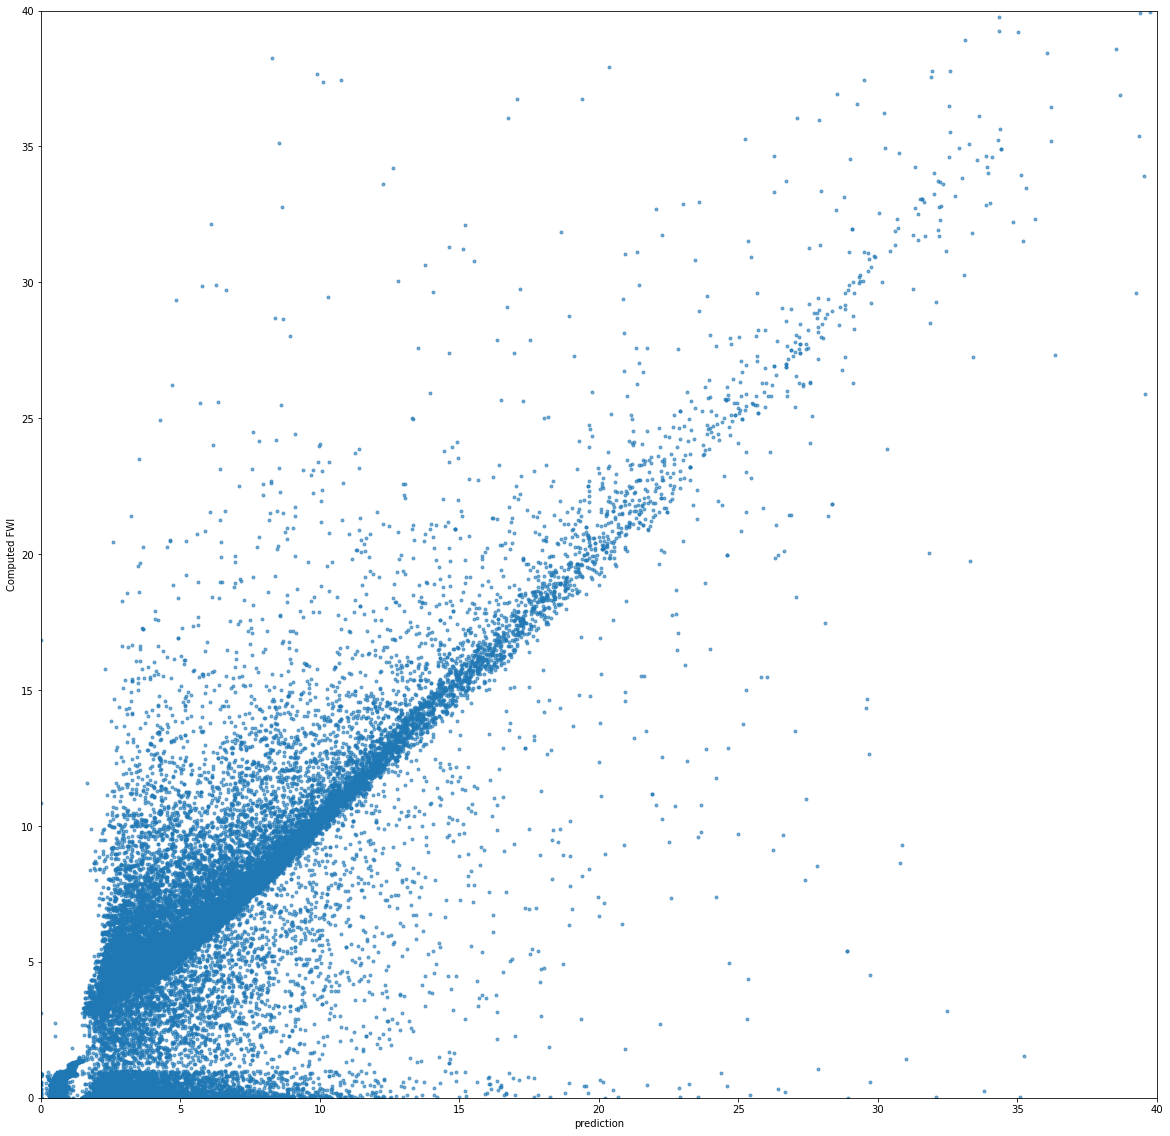

In [62]:
from pylab import *

figure(figsize = (20,20))
plot(model.predict(test_features.reshape(-1,3)), test_labels,".",alpha = 0.6)
xlabel("prediction")
ylabel("Computed FWI")
ylim(0,40)
xlim(0,40)

C:\Users\Liam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Exception: Data must be 1-dimensional

<Figure size 1440x1440 with 0 Axes>

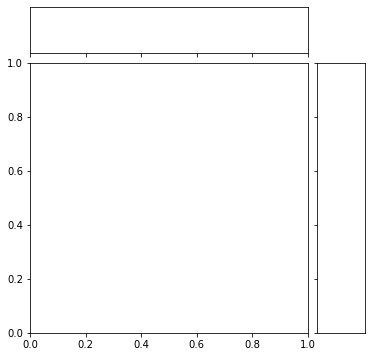

In [63]:
import seaborn as sns

figure(figsize = (20,20))
sns.jointplot(model.predict(test_features.reshape(-1,3)), test_labels,kind = 'kde')
xlabel("prediction")
ylabel("Computed FWI")
ylim(0,40)
xlim(0,40)